In [1]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import networkx as nx
import scipy
import plotly.express as px
from typing import Optional, Union
import plotly.graph_objects as go

In [2]:
def cohen_d(group1_mean: float, group2_mean: float, pooled_std: float) -> float:
    """
    Calculates Cohen's d effect size for two group means.
    
    Parameters
    ----------
    group1_mean : float
        Mean of the first group.
    group2_mean : float
        Mean of the second group.
    pooled_sd : float
        Pooled standard deviation of both groups.
        
    Returns
    -------
    float
        Cohen's d effect size.
    """
    if pooled_std <= 0:
        raise ValueError("Pooled standard deviation must be greater than zero.")
    
    return abs(group1_mean - group2_mean) / pooled_std

In [3]:
effect_size = cohen_d(160, 145, 45)
effect_size

0.3333333333333333

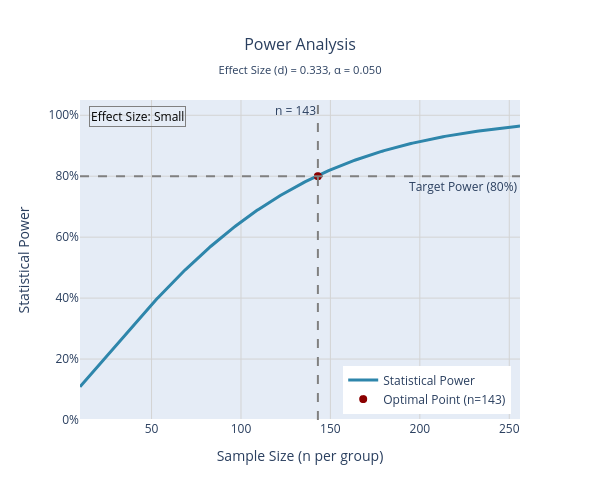

In [4]:
def power_curve(
    effect_size: float, 
    alpha: float = 0.05, 
    power_target: float = 0.80, 
    height: int = 500, 
    width: int = 600, 
    fig_type: Optional[str] = None,
) -> Optional[go.Figure]:
    """
    Generates an interactive Power Analysis plot (Power vs. Sample Size).

    Parameters
    ----------
    effect_size : float
        Cohen's d Effect Size to be detected. Must be positive.
    alpha : float, optional
        Significance level (Type I Error probability). Must be between 0 and 1. Default is 0.05.
    power_target : float, optional
        Target statistical power. Must be between 0 and 1. Default is 0.80.
    max_n : int, optional
        Maximum sample size to plot. If None, automatically calculated as 1.5x required sample size.
    min_n : int, optional
        Minimum sample size to plot. Default is 5.
    height : int, optional
        Plot height in pixels. Default is 500.
    width : int, optional
        Plot width in pixels. Default is 600.
    fig_type : str, optional
        Output format for the plot ('png', 'html', 'svg', etc.). If None, returns Figure object.

    Returns
    -------
    plotly.graph_objects.Figure or None
        Interactive Plotly Figure object if fig_type is None, otherwise None.

    Raises
    ------
    ValueError
        If parameters are outside valid ranges.
    """

    if effect_size <= 0:
        raise ValueError("Effect size must be greater than zero.")
    if not (0 < alpha < 1):
        raise ValueError("Alpha must be between 0 and 1.")
    if not (0 < power_target < 1):
        raise ValueError("Power target must be between 0 and 1.")

    analysis = TTestIndPower()
    n_required = analysis.solve_power(
        effect_size=effect_size,
        alpha=alpha,
        power=power_target,
        ratio=1.0,
        alternative='two-sided'
    )
    
    sample_sizes = np.arange(10, int(n_required * 1.8) + 1, 1)

    powers = analysis.power(
        effect_size=effect_size,
        nobs1=sample_sizes,
        alpha=alpha,
        ratio=1.0,
        alternative='two-sided'
    )

    n_optimal = int(np.ceil(n_required))

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=sample_sizes,
        y=powers,
        mode='lines',
        name='Statistical Power',
        line=dict(color='#2E86AB', width=3),
        hovertemplate='<b>Sample Size:</b> %{x}<br><b>Power:</b> %{y:.2%}<extra></extra>'
    ))
    fig.add_hline(
        y=power_target,
        line_dash="dash",
        line_color="grey",
        line_width=2,
        annotation_text=f"Target Power ({power_target:.0%})",
        annotation_position="bottom right"
    )
    fig.add_vline(
        x=n_optimal,
        line_dash="dash",
        line_color="grey",
        line_width=2,
        annotation_text=f"n = {n_optimal}",
        annotation_position="top left"
    )
    fig.add_trace(go.Scatter(
        x=[n_optimal],
        y=[power_target],
        mode='markers',
        name=f'Optimal Point (n={n_optimal})',
        marker=dict(
            size=6,
            color='darkred',
            symbol='circle',
            line=dict(width=2, color='darkred')
        ),
        hovertemplate=f'<b>Optimal Sample Size:</b> {n_optimal}<br><b>Target Power:</b> {power_target:.0%}<extra></extra>'
    ))
    fig.update_layout(
        title=dict(
            text=f'Power Analysis<br><sub>Effect Size (d) = {effect_size:.3f}, α = {alpha:.3f}</sub>',
            x=0.5,
            font=dict(size=16)
        ),
        xaxis=dict(
            title='Sample Size (n per group)',
            title_font=dict(size=14),
            tickfont=dict(size=12),
            gridcolor='lightgray'
        ),
        yaxis=dict(
            title='Statistical Power',
            title_font=dict(size=14),
            tickformat=".0%",
            range=[0, 1.05],
            tickfont=dict(size=12),
            gridcolor='lightgray'
        ),
        showlegend=True,
        legend=dict(
            orientation="v",
            yanchor="bottom",
            y=0.02,
            xanchor="right",
            x=0.98
        ),
        hovermode="x unified",
        height=height,
        width=width
    )

    effect_interpretation = ""
    if effect_size < 0.2:
        effect_interpretation = "Very Small"
    elif effect_size < 0.5:
        effect_interpretation = "Small"
    elif effect_size < 0.8:
        effect_interpretation = "Medium"
    else:
        effect_interpretation = "Large"

    fig.add_annotation(
        x=0.02,
        y=0.98,
        xref="paper",
        yref="paper",
        text=f"Effect Size: {effect_interpretation}",
        showarrow=False,
        font=dict(size=12, color="black"),
        bordercolor="gray",
        borderwidth=1
    )

    return fig.show(fig_type)

fig = power_curve(
    effect_size=1/3,
    alpha=0.05,
    power_target=0.80,
    fig_type='png'
)

fig

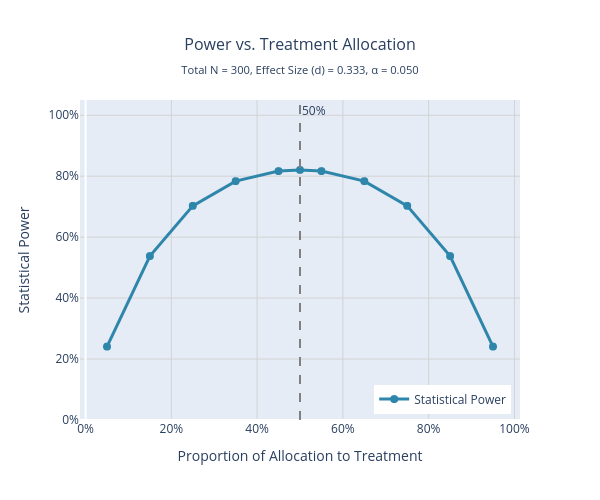

In [5]:
def power_vs_allocation(effect_size, sample_size, alpha=0.05, height=500, width=600, fig_type=None):
    """
    Calculates and plots the Statistical Power curve as a function of the Proportion of 
    Customers allocated to the treatment group, keeping the total sample size fixed.

    Power is maximized when the allocation proportion is 0.5 (equal groups).

    Parameters
    ----------
    effect_size : float
        Cohen's d Effect Size fixed for the calculation.
    sample_size : int
        Total and fixed sample size (Control + Treatment).
    alpha : float, optional
        Significance level (Type I Error probability). Default is 0.05.
    height : int, optional
        Plot height in pixels. Default is 500.
    width : int, optional
        Plot width in pixels. Default is 600.
    fig_type : str, optional
        Output format for the plot ('png', 'html', 'svg', etc.). If None, returns Figure object.

    Returns
    -------
    plotly.graph_objects.Figure or None
        Interactive Plotly Figure object if fig_type is None, otherwise None.

    Raises
    ------
    ValueError
        If total sample size is not positive.
    """

    if sample_size <= 0:
        raise ValueError("Total sample size must be positive.")
    if effect_size <= 0:
        raise ValueError("Effect size must be greater than zero.")
    if not (0 < alpha < 1):
        raise ValueError("Alpha must be between 0 and 1.")
        
    analysis = TTestIndPower()
    
    treatment_proportions = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.50, 0.55, 0.65, 0.75, 0.85, 0.95])
    
    powers = []
    
    for p_treat in treatment_proportions:
        
        if p_treat == 0.5:
             current_ratio = 1.0
        else:
             current_ratio = p_treat / (1.0 - p_treat)
        
        n_control = sample_size * (1.0 - p_treat)

        if n_control < 2:
            powers.append(0)
            continue
            
        calculated_power = analysis.power(
            effect_size=effect_size,
            nobs1=n_control,
            alpha=alpha,
            ratio=current_ratio,
            alternative='two-sided'
        )
        powers.append(calculated_power)

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=treatment_proportions,
        y=powers,
        mode='lines+markers',
        name='Statistical Power',
        line=dict(color='#2E86AB', width=3),
        marker=dict(size=8, color='#2E86AB'),
        hovertemplate='<b>Treatment Allocation:</b> %{x:.0%}<br><b>Power:</b> %{y:.2%}<extra></extra>'
    ))

    fig.add_vline(
        x=0.50, 
        line_dash="dash", 
        line_color="grey", 
        line_width=2,
        annotation_text="50%", 
        annotation_position="top right"
    )

    fig.update_layout(
        title=dict(
            text=f'Power vs. Treatment Allocation<br><sub>Total N = {sample_size}, Effect Size (d) = {effect_size:.3f}, α = {alpha:.3f}</sub>',
            x=0.5,
            font=dict(size=16)
        ),
        xaxis=dict(
            title="Proportion of Allocation to Treatment",
            title_font=dict(size=14),
            tickformat=".0%",
            tickfont=dict(size=12),
            gridcolor='lightgray'
        ),
        yaxis=dict(
            title="Statistical Power",
            title_font=dict(size=14),
            tickformat=".0%",
            range=[0, 1.05],
            tickfont=dict(size=12),
            gridcolor='lightgray'
        ),
        showlegend=True,
        legend=dict(
            orientation="v",
            yanchor="bottom",
            y=0.02,
            xanchor="right",
            x=0.98
        ),
        hovermode="x unified",
        height=height,
        width=width
    )

    return fig.show(fig_type)

fig_allocation = power_vs_allocation(
    effect_size=1/3,
    sample_size=300,
    alpha=0.05,
    fig_type='png'
)
fig_allocation

In [6]:
import pandas as pd

In [7]:
np.random.seed(42)

def generate_synthetic_data(n_samples=1500):
    """
    Gera dados sintéticos para teste da função norm_diff com 3 grupos
    
    Parameters
    ----------
    n_samples : int
        Número de amostras a gerar
        
    Returns
    -------
    pd.DataFrame
        DataFrame com colunas: gender, age, group
    """
    
    # Gerar grupos: controle, treatment1 (similar), treatment2 (diferente)
    group = np.random.choice(['control', 'treatment1', 'treatment2'], n_samples, p=[0.33, 0.33, 0.34])
    
    gender = []
    age_means = []
    
    for g in group:
        if g == 'control':
            # Controle: 50% homens, 50% mulheres
            gender.append(np.random.choice(['M', 'F'], p=[0.5, 0.5]))
            age_means.append(35)  # média de idade 35
        elif g == 'treatment1':
            # Treatment1: similar ao controle (55% homens, 45% mulheres)
            gender.append(np.random.choice(['M', 'F'], p=[0.55, 0.45]))
            age_means.append(36)  # média ligeiramente maior
        else:  # treatment2
            # Treatment2: muito diferente (25% homens, 75% mulheres)
            gender.append(np.random.choice(['M', 'F'], p=[0.25, 0.75]))
            age_means.append(32)  # média menor
    
    # Gerar idades com diferentes médias por grupo
    age = []
    for i, g in enumerate(group):
        if g == 'control':
            age.append(np.random.normal(35, 12))
        elif g == 'treatment1':
            age.append(np.random.normal(36, 12))
        else:  # treatment2
            age.append(np.random.normal(32, 13))
    
    age = np.array(age)
    age = np.clip(age, 18, 70)  # Limitar entre 18 e 70 anos
    
    # Converter gênero para numérico
    gender = pd.Series(gender).map({'M': 1, 'F': 0})

    return pd.DataFrame({
        'gender': gender,
        'age': age,
        'group': group,
    })

df = generate_synthetic_data(1500)

In [8]:
def balance_table(df, features, group_col='group', treatment='treatment', control='control'):
    """
    Calcula a diferença normalizada para todas as features numéricas entre grupos.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame com os dados
    group_col : str
        Nome da coluna que identifica os grupos
    treatment_name : str
        Nome do grupo de tratamento
    control_name : str
        Nome do grupo de controle
        
    Returns
    -------
    pd.DataFrame
        DataFrame com as diferenças normalizadas por feature
    """

    if not all(feature in df.columns for feature in features):
        missing_features = [feature for feature in features if feature not in df.columns]
        raise ValueError(f"Features not found in DataFrame columns: {missing_features}")


    if isinstance(features, str):
        features = [features]
    if isinstance(treatment, str):
        treatment = [treatment]


    results = []

    stats = df.groupby(group_col, group_keys=True)[features].agg(['mean', 'var'])

    for group in treatment:

        for feature in features:
            
            mean_diff = np.abs(stats.loc[control][feature]["mean"] - stats.loc[group][feature]["mean"])
            pooled_var = (stats.loc[control][feature]["var"] + stats.loc[group][feature]["var"]) / 2
            cohen_d_value = mean_diff / np.sqrt(pooled_var)
            
            results.append({
                "group": group,
                'feature': feature,
                'cohen_d': cohen_d_value
            })
        
    return pd.DataFrame(results)

In [9]:
balance_table(df, features=["gender", "age"], treatment=['treatment1', 'treatment2'], control='control')

,group,feature,cohen_d
0,treatment1,gender,0.158026
1,treatment1,age,0.011620
2,treatment2,gender,0.503795
3,treatment2,age,0.290087


In [10]:
def confidence_intervals(
    df: pd.DataFrame,
    feature: str,
    group_col: str,
    confidence: float = 0.95,
    fig_type: Optional[str] = None,
    height: int = 500,
    width: int = 700,
) -> go.Figure:
    """
    Calculates and plots the confidence interval for the mean of a feature,
    grouped by a categorical column, using the Student's t-distribution.

    This function creates an interactive scatter plot with error bars showing the mean
    values and confidence intervals for a numerical feature across different groups.
    The confidence intervals are calculated using the Student's t-distribution, which
    is appropriate for small sample sizes and when the population standard deviation
    is unknown.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing the data to analyze.
    feature : str
        The name of the numerical column for which to calculate the mean and
        confidence interval. Must be a column name that exists in the DataFrame.
    group_col : str
        The name of the categorical column to group by. Must be a column name
        that exists in the DataFrame.
    confidence : float, default=0.95
        The desired confidence level (between 0 and 1). Common values are 0.90,
        0.95, and 0.99. Default is 0.95 (95% confidence interval).

    Returns
    -------
    plotly.graph_objects.Figure
        A Plotly Figure object displaying the means and their confidence intervals
        as a scatter plot with error bars. The plot includes hover information
        showing the exact confidence interval bounds.

    Raises
    ------
    ValueError
        If confidence level is not between 0 and 1.
    KeyError
        If feature or group_col columns do not exist in the DataFrame.
    """
    if not (0 < confidence < 1):
        raise ValueError("Confidence level must be between 0 and 1.")
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame.")
    if feature not in df.columns:
        raise KeyError(f"Feature column '{feature}' not found in DataFrame.")
    if group_col not in df.columns:
        raise KeyError(f"Group column '{group_col}' not found in DataFrame.")

    def t_confidence_interval(
        data: np.ndarray,
        confidence: float = 0.95,
    ) -> tuple:
        """
        Calculates the confidence interval (lower, upper) for the mean
        using the Student's t-distribution.
        """

        if isinstance(data, pd.Series):
            data = data.to_numpy()

        if len(data) < 2:
            return (np.nan, np.nan)

        return scipy.stats.t.interval(
            confidence, len(data) - 1, loc=np.mean(data), scale=scipy.stats.sem(data)
        )

    stats = df.groupby(group_col)[feature].agg(["mean"]).reset_index()

    intervals = df.groupby(group_col)[feature].apply(
        t_confidence_interval, confidence=confidence
    )
    intervals_df = intervals.apply(pd.Series).rename(
        columns={0: "ci_lower", 1: "ci_upper"}
    )
    intervals_df = intervals_df.reset_index()

    plot_data = pd.merge(stats, intervals_df, on=group_col)

    plot_data["error_minus"] = plot_data["mean"] - plot_data["ci_lower"]
    plot_data["error_plus"] = plot_data["ci_upper"] - plot_data["mean"]

    fig = px.scatter(
        plot_data,
        x=group_col,
        y="mean",
        error_y="error_plus",
        error_y_minus="error_minus",
        title=f"Mean and {int(confidence*100)}% Confidence Interval of {feature} by {group_col}",
        labels={"mean": f"Mean of {feature}", group_col: group_col},
    )

    fig.update_traces(
        marker_color="#2E86AB",
        name="Mean",
        hovertemplate=f"<b>{group_col}:</b> %{{x}}<br><b>Mean:</b> %{{y:.2f}}<br><b>CI:</b> [%{{customdata[0]:.2f}}, %{{customdata[1]:.2f}}] <extra></extra>",
        customdata=plot_data[["ci_lower", "ci_upper"]].values,
    )

    fig.update_layout(
        title_x=0.5,
        xaxis=dict(
            title_font=dict(size=14), tickfont=dict(size=12), gridcolor="lightgray"
        ),
        yaxis=dict(
            title_font=dict(size=14), tickfont=dict(size=12), gridcolor="lightgray"
        ),
        hovermode="x unified",
        height=height,
        width=width,
    )

    return fig.show(fig_type)


In [11]:
confidence_intervals(df, feature='age', group_col='group', confidence=0.95)

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

In [13]:
model = nx.DiGraph([
    ("C", "A"),
    ("C", "B"),
    ("D", "A"),
    ("B", "E"),
    ("F", "E"),
    ("A", "G"),

])

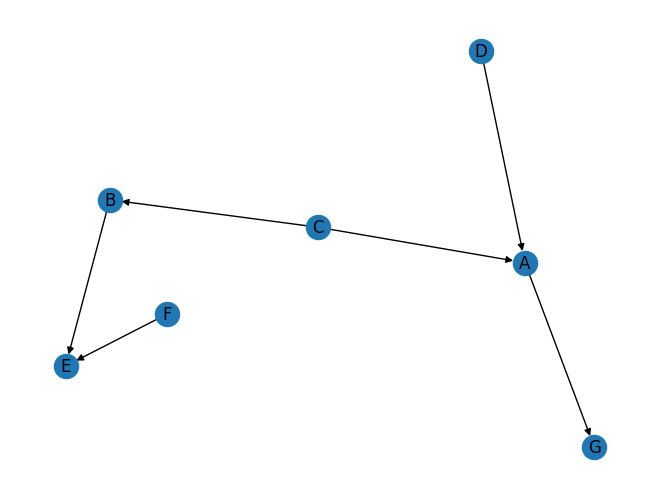

In [14]:
nx.draw(model, with_labels=True)

In [15]:
print("Are D and C independent given A?")
nx.is_d_separator(model, {"D"}, {"C"}, {"A"})

Are D and C independent given A?


False

In [16]:
print("Are D and C independent?")
nx.is_d_separator(model, {"D"}, {"C"}, set())

Are D and C independent?


True

In [17]:
print("Are D and C independent given G?")
nx.is_d_separator(model, {"D"}, {"C"}, {"G"})

Are D and C independent given G?


False

In [18]:
print("Area A and B independent?")
nx.is_d_separator(model, {"A"}, {"B"}, set())

Area A and B independent?


False

In [19]:
print("Area A and B independent given C?")
nx.is_d_separator(model, {"A"}, {"B"}, {"C"})

Area A and B independent given C?


True

In [20]:
print("Are G and F independent?")
nx.is_d_separator(model, {"G"}, {"F"}, set())

Are G and F independent?


True

In [21]:
print("Are G and F independent given E?")
nx.is_d_separator(model, {"G"}, {"F"}, {"E"})

Are G and F independent given E?


False

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)
N_clientes = 1000
dados = pd.DataFrame({
    'ID_Cliente': range(1, N_clientes + 1),
    'Pontuacao_Risco': np.random.randint(300, 850, N_clientes)
})

# 2. Definição dos Estratos (Buckets) e dos Parâmetros Beta

# A lógica é: clientes com maior Pontuação_Risco devem ser amostrados
# de uma distribuição que puxe os resultados para valores mais altos (melhor tratamento).
# Lembre-se que a média da Beta é: alpha / (alpha + beta)

parametros_beta = {
    'Baixo Risco (Score Alto)': {'min_score': 700, 'alpha': 10, 'beta': 2},    # Média alta (~0.83)
    'Risco Médio': {'min_score': 550, 'alpha': 5, 'beta': 5},                   # Média mediana (0.5)
    'Alto Risco (Score Baixo)': {'min_score': 300, 'alpha': 2, 'beta': 10}      # Média baixa (~0.16)
}

def realizar_amostragem_beta(row):
    score = row['Pontuacao_Risco']
    
    if score >= parametros_beta['Baixo Risco (Score Alto)']['min_score']:
        estrato = 'Baixo Risco (Score Alto)'
    elif score >= parametros_beta['Risco Médio']['min_score']:
        estrato = 'Risco Médio'
    else:
        estrato = 'Alto Risco (Score Baixo)'
    
    alpha = parametros_beta[estrato]['alpha']
    beta = parametros_beta[estrato]['beta']
    
    tratamento_amostrado = np.random.beta(alpha, beta)
    
    return estrato, tratamento_amostrado


resultados = dados.apply(
    lambda row: realizar_amostragem_beta(row), 
    axis=1, 
    result_type='expand'
)

In [26]:

dados[['Estrato', 'Nivel_Tratamento_Beta']] = resultados

print("Primeiras 10 linhas do resultado da Amostragem Beta Condicional:\n")
print(dados.head(10))

# Média do Nível de Tratamento por Estrato (Para Confirmação)
print("\nVerificação das Médias de Tratamento por Estrato:\n")
print(dados.groupby('Estrato')['Nivel_Tratamento_Beta'].mean().sort_values(ascending=False))

Primeiras 10 linhas do resultado da Amostragem Beta Condicional:

   ID_Cliente  Pontuacao_Risco                   Estrato  \
0           1              402  Alto Risco (Score Baixo)   
1           2              735  Baixo Risco (Score Alto)   
2           3              570               Risco Médio   
3           4              406  Alto Risco (Score Baixo)   
4           5              371  Alto Risco (Score Baixo)   
5           6              320  Alto Risco (Score Baixo)   
6           7              421  Alto Risco (Score Baixo)   
7           8              766  Baixo Risco (Score Alto)   
8           9              514  Alto Risco (Score Baixo)   
9          10              630               Risco Médio   

   Nivel_Tratamento_Beta  
0               0.235760  
1               0.757500  
2               0.436318  
3               0.047901  
4               0.327723  
5               0.149065  
6               0.312737  
7               0.617093  
8               0.180641  
9  

In [27]:
dados

,ID_Cliente,Pontuacao_Risco,Estrato,Nivel_Tratamento_Beta
0,1,402,Alto Risco (Score Baixo),0.235760
1,2,735,Baixo Risco (Score Alto),0.757500
2,3,570,Risco Médio,0.436318
3,4,406,Alto Risco (Score Baixo),0.047901
4,5,371,Alto Risco (Score Baixo),0.327723
...,...,...,...,...
995,996,316,Alto Risco (Score Baixo),0.374951
996,997,452,Alto Risco (Score Baixo),0.102270
997,998,677,Risco Médio,0.260031
998,999,641,Risco Médio,0.457863
